In [ ]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import defaultdict
import re
import pandas as pd
df = pd.read_csv('Status Updates.csv')
df

,userid,message
0,0003e82099f3087d16b301104330547c,is still pissed that Eminem wasnt in the offic...
1,001494c3b74f124a2e3435fff17f376b,is singing today and is a little nurvous . ple...
2,00257e647892d77d5f9b4c33a664e6f7,I had a wonderful day at Anderson I am beat ...
3,002bc06dc29c9ebd31ea3d40d4e13861,i like it on the floor! :)\ti hope you miss me...
4,004ed92354145c51355bd757a0733b1a,is about to make some moolah!\tI need to start...
...,...,...
2995,ffb6718745970df248f91730908ad72b,I have had a long day. I did a lot of little ...
2996,ffc0a320c8156f827e5b951b060feb5c,I don't care; Im going to bed. Im gonna pick u...
2997,ffd35a209f0b32bea09bdfb4f6bad1a1,I LUBEN YOU BANEY!!\tis at work wishing i cou...
2998,ffdf4c6a87a23e1a17e77ea7babbb117,is sore!\tis thinking that today could be a lo...


PART 1:

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

# Initialize the WordNetLemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
english_vocab = set(w.lower() for w in words.words())

# Mapping between POS tags and WordNet's
tag_map = defaultdict(lambda: nltk.corpus.wordnet.NOUN)
tag_map['J'] = nltk.corpus.wordnet.ADJ
tag_map['V'] = nltk.corpus.wordnet.VERB
tag_map['R'] = nltk.corpus.wordnet.ADV

def preprocess_text(text):
    # Lowercase, remove digits and punctuation
    text = text.lower()
    text = re.sub(r'[\d]|[^\w\s]', '', text)

    # Tokenize, POS tagging, lemmatize, remove stopwords and short words
    tokens = word_tokenize(text)
    lemmas = [
        lemmatizer.lemmatize(token, tag_map[tag[0]])
        for token, tag in pos_tag(tokens)
        if token not in stop_words and len(token) > 2
    ]
    return lemmas

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
def calculate_metrics(text):
    # Tokenization and raw length
    raw_tokens = word_tokenize(text)
    raw_length = len(raw_tokens)

    # Cleaned text and length
    cleaned_tokens = preprocess_text(text)
    cleaned_length = len(cleaned_tokens)

    # Lexical diversity
    lexical_diversity = len(set(cleaned_tokens)) / cleaned_length if cleaned_length > 0 else 0

    # Potential misspells
    misspells = sum(1 for word in cleaned_tokens if word not in english_vocab)

    return raw_length, cleaned_length, lexical_diversity, misspells

# Apply preprocess function on df column message
df['preprocessed_message'] = df['message'].apply(preprocess_text)

# Apply the metrics function to message and create columns for said metrics
metrics = df['message'].apply(lambda x: calculate_metrics(x) if isinstance(x, str) else (0,0,0,0))

pt1 = pd.DataFrame(metrics.tolist(), columns=['Message Length', 'Cleaned Message Length', 'Lexical Diversity', 'Potential Misspells'], index=df.index)

unique_userids = pd.Series(df['userid'].unique()).sort_values()

# Create a dictionary mapping each unique userid to a new numerical label
userid_to_numlabel = {userid: i+1 for i, userid in enumerate(unique_userids)}

# Map the original userids to their new numerical labels
df['Numerical ID'] = df['userid'].map(userid_to_numlabel)

pt1[ 'Status update messages'] = df['Numerical ID']

# Rearrange columns order if needed
pt1 = pt1[['Status update messages', 'Message Length', 'Cleaned Message Length', 'Lexical Diversity', 'Potential Misspells']]

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

print(pt1.head(5))

   Status update messages  Message Length  Cleaned Message Length  Lexical Diversity  Potential Misspells
0                       1             157                      66               0.97                   16
1                       2            2482                     997               0.47                  122
2                       3             672                     274               0.68                   10
3                       4             685                     274               0.68                   29
4                       5            1453                     596               0.65                   51


PT 2:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert each list of preprocessed tokens back into a string
df['preprocessed_message_str'] = df['preprocessed_message'].apply(lambda tokens: ' '.join(tokens))

#groupby preprocessed messages by ID
combined_texts = df.groupby('userid')['preprocessed_message_str'].apply(lambda texts: ' '.join(texts))

# Initialize and fit the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
tfidf_vectors = vectorizer.fit_transform(combined_texts)



In [ ]:
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
# Load GloVe vectors
glove_path = '/content/drive/My Drive/Mydata/glove.twitter.27B.100d.txt'
def load_glove_model(glove_file):
    print("Loading Glove Model")
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            embedding = np.array(parts[1:], dtype=np.float32)
            glove_model[word] = embedding
    print("Done.", len(glove_model), "words loaded!")
    return glove_model

glove_model = load_glove_model(glove_path)

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_model[word] = vector

# Function to create document vectors by averaging word vectors
def document_vector_glove(text):
    vectors = [glove_model[word] for word in text.split() if word in glove_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

# Apply the function to each combined user text
glove_vectors = combined_texts.apply(document_vector_glove)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading Glove Model
Done. 1193515 words loaded!


In [ ]:
from transformers import LongformerModel, LongformerTokenizer

tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerModel.from_pretrained('allenai/longformer-base-4096')

def get_longformer_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=4096)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()[0]

# Long Form Embedding
longformer_embeddings = np.array([get_longformer_embedding(text) for text in combined_texts])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Input ids are automatically padded from 91 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1218 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 296 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 330 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 678 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 109 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 632 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 243 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 129 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1015 to 1024 to be a multiple of `confi

In [ ]:
embeddings_save_path = '/content/drive/My Drive/longformer_embeddings.npy'
import numpy as np

# Save the embeddings
np.save(embeddings_save_path, longformer_embeddings)
# Load the embeddings
loaded_embeddings = np.load(embeddings_save_path)

PT3: In Doc


PT4:

In [ ]:
import pandas as pd
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

#  NLTK data
nltk.download('vader_lexicon')

# Assuming df is your DataFrame with ''Numerical ID' and 'preprocessed_message' columns
# Initialize NLTK's VADER
sa = SentimentIntensityAnalyzer()

def analyze_sentiment(text_list):
    # Join the list of tokens into a single string if necessary
    text = ' '.join(text_list) if isinstance(text_list, list) else text_list

    # TextBlob analysis
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    # NLTK VADER analysis
    nltk_compound = sa.polarity_scores(text)['compound']

    return polarity, subjectivity, nltk_compound

# Apply SA on message
df[['Polarity', 'Subjectivity', 'NLTK_Compound']] = df.apply(lambda x: analyze_sentiment(x['preprocessed_message']), axis=1, result_type='expand')

# Group by 'Numerical ID' and calculate mean sentiment values
sa_results = df.groupby('Numerical ID')[['Polarity', 'Subjectivity', 'NLTK_Compound']].mean().reset_index()

# Display the first 5
print(sa_results.head(5))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


   Numerical ID  Polarity  Subjectivity  NLTK_Compound
0             1      0.02          0.51          -0.97
1             2      0.28          0.54           1.00
2             3      0.40          0.62           1.00
3             4      0.01          0.51           0.91
4             5      0.16          0.53           1.00


PT5:

In [ ]:
df3

,userid,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function.,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,8f9d4ed5d16ed1a67d734196d29d1f6b,79.76,49.84,49.65,57.18,12.59,18.03,75.41,44.85,10.62,7.09,3.93,0.69,1.13,0.85,0.49,3.53,5.96,13.49,7.62,4.74,3.32,1.99,14.55,4.17,1.18,1.18,2.43,1.50,5.23,3.44,1.78,0.12,0.53,0.53,7.05,0.32,0.24,0.28,1.13,8.43,1.38,0.97,1.38,2.35,1.22,2.43,2.67,1.30,0.77,0.61,2.03,0.77,0.57,0.32,0.49,7.13,1.94,1.30,2.92,1.62,0.49,2.55,11.14,1.99,15.44,2.07,6.56,7.29,2.43,1.99,0.24,0.89,0.32,0.65,1.54,0.57,0.45,0.32,0.08,0.00,18.27,7.82,3.04,0.49,0.00,0.53,1.46,0.81,1.05,1.74,0.41,0.93
1,325e62f4e7e4f64a03fcf831a8d80bf1,32.33,40.50,57.82,80.53,9.39,13.53,91.90,56.25,16.76,9.96,5.84,0.21,2.13,1.03,0.76,6.73,4.46,12.36,9.41,8.52,6.39,2.68,20.12,4.95,1.99,1.99,1.37,1.58,9.48,6.25,3.23,0.27,0.76,0.69,8.72,0.27,0.41,0.69,0.62,18.06,3.16,2.06,3.91,4.05,2.27,4.46,1.79,0.69,0.21,0.76,3.09,0.76,1.58,0.07,0.41,7.97,1.58,2.47,2.61,2.82,0.76,2.40,14.56,2.40,13.67,1.92,6.80,5.49,1.58,0.62,0.34,0.76,0.76,0.14,1.92,0.48,0.96,0.07,0.48,0.00,14.29,6.87,2.27,0.07,0.00,1.85,1.92,0.14,0.00,1.10,0.00,0.07
2,d9d94cb467090189a08fb103b9cd5a0c,81.87,40.83,80.19,86.26,7.69,15.99,85.10,43.14,10.23,6.92,5.49,0.17,0.64,0.20,0.42,3.31,6.10,13.42,6.47,4.77,4.25,1.56,16.21,5.61,1.33,1.11,2.45,1.36,6.80,5.14,1.66,0.17,0.42,0.32,5.66,0.47,0.47,0.57,0.44,7.81,1.28,0.94,1.80,1.90,1.28,1.53,2.99,1.41,0.64,0.64,3.21,0.82,0.64,0.07,1.63,7.07,1.09,1.51,1.98,2.55,0.42,3.19,10.72,2.30,19.79,3.51,7.41,9.59,3.01,2.89,1.53,0.82,0.42,0.22,2.00,0.22,0.52,0.74,0.35,0.17,29.73,14.48,2.67,0.15,0.02,1.73,7.07,0.37,0.79,1.75,0.25,0.44
3,a7637e86876374b952f4d10d0513c350,63.11,53.43,72.23,72.35,9.00,14.59,83.71,47.35,12.71,8.71,5.11,0.46,2.09,0.58,0.48,3.99,5.86,11.54,8.86,4.86,5.07,1.71,16.75,4.94,1.94,1.22,1.55,1.88,6.92,4.66,2.17,0.26,0.59,0.44,8.09,0.40,0.38,1.04,0.26,9.55,1.63,0.64,1.84,2.49,1.37,2.80,2.55,1.20,0.54,0.66,3.05,0.92,0.51,0.03,1.17,6.69,2.22,1.56,1.99,1.40,0.30,2.83,11.71,2.70,17.42,3.26,7.30,7.18,2.60,2.52,0.66,0.63,0.26,0.07,2.21,0.16,1.07,0.56,0.44,0.02,28.84,12.78,3.51,0.48,0.10,0.86,2.80,1.75,1.00,2.87,1.42,1.28
4,c5898ecc4c7407e6f07cc3485073d3a6,85.73,60.94,23.37,18.00,12.84,22.80,72.31,40.05,8.69,4.77,1.55,0.20,1.92,0.69,0.41,3.87,7.01,12.03,6.28,3.83,4.65,1.14,12.64,4.57,1.71,1.47,3.26,1.84,5.55,2.49,3.02,0.37,1.39,0.53,6.73,0.20,0.49,0.29,0.90,8.97,1.71,1.59,1.47,2.32,0.94,2.65,3.06,1.35,0.86,0.49,3.14,0.65,0.69,0.24,1.47,5.71,1.31,0.90,2.37,0.90,0.65,2.61,8.52,0.73,12.89,1.96,6.89,4.08,3.22,2.08,0.33,1.02,0.16,0.41,1.63,0.73,0.49,0.16,0.24,0.04,26.84,8.61,4.65,1.92,0.12,0.94,0.57,1.67,2.12,2.98,0.98,2.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,34e61f471ed71bd2afe479e1fc776ba4,38.83,31.82,78.01,41.90,7.89,15.70,85.81,49.69,18.71,12.41,9.25,0.27,2.19,0.21,0.48,6.31,4.93,10.42,8.57,6.10,4.59,1.85,18.23,4.25,1.58,1.71,2.40,1.71,8.50,4.66,3.77,0.34,1.78,0.89,8.84,0.48,0.34,0.55,0.55,13.30,2.06,1.78,2.06,3.50,2.12,3.22,2.19,1.10,0.62,0.34,3.91,1.78,0.55,1.23,0.34,5.89,1.37,1.10,2.54,1.17,0.41,3.36,12.89,2.33,13.37,2.19,5.83,5.62,1.23,1.64,0.34,0.21,0.14,0.41,4.11,1.71,1.99,0.21,0.34,0.07,26.39,14

In [ ]:
#Load DF and merge other dfs

df2 = pd.read_csv('Openness_w_profile_w_activity.csv')
df3 = pd.read_csv('LIWC.csv')

df = pd.merge(df, df2[['userid', 'ope_hl_bol']], on='userid', how='left')


In [ ]:
df

,userid,message,preprocessed_message,Message Length,Cleaned Message Length,Lexical Diversity,Potential Misspells,Numerical ID,preprocessed_message_str,Polarity,Subjectivity,NLTK_Compound,ope_hl_bol_x,ope_hl_bol_y,ope_hl_bol
0,0003e82099f3087d16b301104330547c,is still pissed that Eminem wasnt in the offic...,"[still, piss, eminem, wasnt, official, airplan...",157,66,0.97,16,1,still piss eminem wasnt official airplane reco...,0.02,0.51,-0.97,1,1,1
1,001494c3b74f124a2e3435fff17f376b,is singing today and is a little nurvous . ple...,"[sing, today, little, nurvous, please, pray, s...",2482,997,0.47,122,2,sing today little nurvous please pray send tho...,0.28,0.54,1.00,1,1,1
2,00257e647892d77d5f9b4c33a664e6f7,I had a wonderful day at Anderson I am beat ...,"[wonderful, day, anderson, beat, good, beat, i...",672,274,0.68,10,3,wonderful day anderson beat good beat importan...,0.40,0.62,1.00,0,0,0
3,002bc06dc29c9ebd31ea3d40d4e13861,i like it on the floor! :)\ti hope you miss me...,"[like, floor, hope, miss, mejust, little, bit,...",685,274,0.68,29,4,like floor hope miss mejust little bit maybe r...,0.01,0.51,0.91,1,1,1
4,004ed92354145c51355bd757a0733b1a,is about to make some moolah!\tI need to start...,"[make, moolah, need, start, play, mafia, war, ...",1453,596,0.65,51,5,make moolah need start play mafia war love dar...,0.16,0.53,1.00,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,ffb6718745970df248f91730908ad72b,I have had a long day. I did a lot of little ...,"[long, day, lot, little, thing, go, rest, cont...",577,240,0.74,17,2996,long day lot little thing go rest continue rea...,0.27,0.55,1.00,0,0,0
2996,ffc0a320c8156f827e5b951b060feb5c,I don't care; Im going to bed. Im gonna pick u...,"[dont, care, go, bed, gon, pick, hairball, cas...",605,256,0.79,19,2997,dont care go bed gon pick hairball casey schin...,0.06,0.44,0.96,1,1,1
2997,ffd35a209f0b32bea09bdfb4f6bad1a1,I LUBEN YOU BANEY!!\tis at work wishing i cou...,"[luben, baney, work, wish, could, see, baney, ...",486,207,0.67,35,2998,luben baney work wish could see baney leave lo...,0.17,0.62,1.00,1,1,1
2998,ffdf4c6a87a23e1a17e77ea7babbb117,is sore!\tis thinking that today could be a lo...,"[sore, think, today, could, long, day, help, d...",742,307,0.63,38,2999,sore think today could long day help dad day b...,0.13,0.49,0.95,0,0,0


In [ ]:
glove_vectors_2d = np.vstack(glove_vectors)

# Check the new shape to ensure it's correctly formatted as (num_samples, embedding_dim)
print(glove_vectors_2d.shape)

(3000, 100)


In [ ]:
y = df['ope_hl_bol'].values
from sklearn.model_selection import train_test_split

X = glove_vectors_2d  # Assuming glove_vectors is already aligned with df['userid']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#GLOVE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Initialize and train the classifier
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
predictions = clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, predictions)
auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy}')
print(f'AUC Score: {auc_score}')


Accuracy: 0.6016666666666667
AUC Score: 0.6472843237477222


In [ ]:
#score was low at 60 accuracy so lets try gridsearch param
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    # Add more parameters here
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_

# Re-evaluate
predictions = best_clf.predict(X_test)
print("Improved accuracy:", accuracy_score(y_test, predictions))


Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Improved accuracy: 0.6133333333333333


In [ ]:
auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f'AUC Score: {auc_score}')

AUC Score: 0.6472843237477222


In [ ]:
#Glove cross validated
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.base import clone
import numpy as np

# Initialize the classifier with the best parameters you've found
clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=200, random_state=42)

# Prepare cross-validation
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

# Lists to store results
accuracy_scores = []
auc_scores = []

# Perform cross-validation
for train_index, test_index in cv.split(X, y):
    # Clone the classifier for a fair comparison
    clf_clone = clone(clf)

    # Split data - For NumPy arrays, you can directly use the indices without .iloc
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model
    clf_clone.fit(X_train, y_train)

    # Make predictions
    predictions = clf_clone.predict(X_test)
    proba_predictions = clf_clone.predict_proba(X_test)[:, 1]

    # Calculate scores
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, proba_predictions)

    # Store scores
    accuracy_scores.append(accuracy)
    auc_scores.append(auc)

# Print the results
print(f'Average accuracy: {np.mean(accuracy_scores)}')
print(f'Average AUC: {np.mean(auc_scores)}')

Accuracy scores: [0.72, 0.62, 0.6533333333333333, 0.6266666666666667, 0.6133333333333333, 0.5266666666666666, 0.7066666666666667, 0.66, 0.66, 0.56, 0.6533333333333333, 0.6333333333333333, 0.54, 0.5733333333333334, 0.6333333333333333, 0.6066666666666667, 0.56, 0.64, 0.6466666666666666, 0.6533333333333333]
AUC scores: [0.7477333333333334, 0.6625777777777778, 0.6451555555555555, 0.6551111111111111, 0.6416, 0.5975111111111111, 0.7372444444444444, 0.6736, 0.6929777777777778, 0.6254222222222223, 0.6986666666666668, 0.6853333333333333, 0.5701333333333334, 0.6199111111111111, 0.6632888888888889, 0.6289777777777779, 0.6060444444444444, 0.6949333333333334, 0.6954666666666667, 0.7157333333333333]


In [ ]:
print(f'Average accuracy: {np.mean(accuracy_scores)}')
print(f'Average AUC: {np.mean(auc_scores)}')

Average accuracy: 0.6243333333333334
Average AUC: 0.6628711111111111


In [ ]:
#LongFormer
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions of Longformer embeddings
pca = PCA(n_components=0.90)
X_reduced = pca.fit_transform(longformer_embeddings)


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train and evaluate the model
clf_longformer = GradientBoostingClassifier(random_state=42)
clf_longformer.fit(X_train, y_train)
predictions = clf_longformer.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("AUC:", roc_auc_score(y_test, clf_longformer.predict_proba(X_test)[:, 1]))


Accuracy: 0.6216666666666667
AUC: 0.6550291124049958


In [ ]:
num_components_retained = pca.n_components_
print(f"Number of components retained to explain 90% of variance: {num_components_retained}")

Number of components retained to explain 90% of variance: 57


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


In [ ]:
#lets try the best parameters
clf_longformer = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=300, random_state=42)

# Train the classifier on the training data
clf_longformer.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf_longformer.predict(X_test)

# Calculate and print the accuracy and AUC on the test set
accuracy = accuracy_score(y_test, predictions)
auc_score = roc_auc_score(y_test, clf_longformer.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc_score}")


Accuracy: 0.61
AUC: 0.6486621627627895


In [ ]:
#classification model that uses LIWC and SA features
#lets create userid for df3 that contains factors
df3.reset_index(drop=True, inplace=True)

# Create Numerical ID for df3 to merge
df3['Numerical ID'] = df.index + 1

#merge to sa_result sto create df
knowledge_driven = df3.merge(sa_results, on='Numerical ID', how='left')

In [ ]:
knowledge_driven

,userid,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function.,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP,Numerical ID,Numerical ID,Polarity,Subjectivity,NLTK_Compound
0,8f9d4ed5d16ed1a67d734196d29d1f6b,79.76,49.84,49.65,57.18,12.59,18.03,75.41,44.85,10.62,7.09,3.93,0.69,1.13,0.85,0.49,3.53,5.96,13.49,7.62,4.74,3.32,1.99,14.55,4.17,1.18,1.18,2.43,1.50,5.23,3.44,1.78,0.12,0.53,0.53,7.05,0.32,0.24,0.28,1.13,8.43,1.38,0.97,1.38,2.35,1.22,2.43,2.67,1.30,0.77,0.61,2.03,0.77,0.57,0.32,0.49,7.13,1.94,1.30,2.92,1.62,0.49,2.55,11.14,1.99,15.44,2.07,6.56,7.29,2.43,1.99,0.24,0.89,0.32,0.65,1.54,0.57,0.45,0.32,0.08,0.00,18.27,7.82,3.04,0.49,0.00,0.53,1.46,0.81,1.05,1.74,0.41,0.93,1,1,0.02,0.51,-0.97
1,325e62f4e7e4f64a03fcf831a8d80bf1,32.33,40.50,57.82,80.53,9.39,13.53,91.90,56.25,16.76,9.96,5.84,0.21,2.13,1.03,0.76,6.73,4.46,12.36,9.41,8.52,6.39,2.68,20.12,4.95,1.99,1.99,1.37,1.58,9.48,6.25,3.23,0.27,0.76,0.69,8.72,0.27,0.41,0.69,0.62,18.06,3.16,2.06,3.91,4.05,2.27,4.46,1.79,0.69,0.21,0.76,3.09,0.76,1.58,0.07,0.41,7.97,1.58,2.47,2.61,2.82,0.76,2.40,14.56,2.40,13.67,1.92,6.80,5.49,1.58,0.62,0.34,0.76,0.76,0.14,1.92,0.48,0.96,0.07,0.48,0.00,14.29,6.87,2.27,0.07,0.00,1.85,1.92,0.14,0.00,1.10,0.00,0.07,2,2,0.28,0.54,1.00
2,d9d94cb467090189a08fb103b9cd5a0c,81.87,40.83,80.19,86.26,7.69,15.99,85.10,43.14,10.23,6.92,5.49,0.17,0.64,0.20,0.42,3.31,6.10,13.42,6.47,4.77,4.25,1.56,16.21,5.61,1.33,1.11,2.45,1.36,6.80,5.14,1.66,0.17,0.42,0.32,5.66,0.47,0.47,0.57,0.44,7.81,1.28,0.94,1.80,1.90,1.28,1.53,2.99,1.41,0.64,0.64,3.21,0.82,0.64,0.07,1.63,7.07,1.09,1.51,1.98,2.55,0.42,3.19,10.72,2.30,19.79,3.51,7.41,9.59,3.01,2.89,1.53,0.82,0.42,0.22,2.00,0.22,0.52,0.74,0.35,0.17,29.73,14.48,2.67,0.15,0.02,1.73,7.07,0.37,0.79,1.75,0.25,0.44,3,3,0.40,0.62,1.00
3,a7637e86876374b952f4d10d0513c350,63.11,53.43,72.23,72.35,9.00,14.59,83.71,47.35,12.71,8.71,5.11,0.46,2.09,0.58,0.48,3.99,5.86,11.54,8.86,4.86,5.07,1.71,16.75,4.94,1.94,1.22,1.55,1.88,6.92,4.66,2.17,0.26,0.59,0.44,8.09,0.40,0.38,1.04,0.26,9.55,1.63,0.64,1.84,2.49,1.37,2.80,2.55,1.20,0.54,0.66,3.05,0.92,0.51,0.03,1.17,6.69,2.22,1.56,1.99,1.40,0.30,2.83,11.71,2.70,17.42,3.26,7.30,7.18,2.60,2.52,0.66,0.63,0.26,0.07,2.21,0.16,1.07,0.56,0.44,0.02,28.84,12.78,3.51,0.48,0.10,0.86,2.80,1.75,1.00,2.87,1.42,1.28,4,4,0.01,0.51,0.91
4,c5898ecc4c7407e6f07cc3485073d3a6,85.73,60.94,23.37,18.00,12.84,22.80,72.31,40.05,8.69,4.77,1.55,0.20,1.92,0.69,0.41,3.87,7.01,12.03,6.28,3.83,4.65,1.14,12.64,4.57,1.71,1.47,3.26,1.84,5.55,2.49,3.02,0.37,1.39,0.53,6.73,0.20,0.49,0.29,0.90,8.97,1.71,1.59,1.47,2.32,0.94,2.65,3.06,1.35,0.86,0.49,3.14,0.65,0.69,0.24,1.47,5.71,1.31,0.90,2.37,0.90,0.65,2.61,8.52,0.73,12.89,1.96,6.89,4.08,3.22,2.08,0.33,1.02,0.16,0.41,1.63,0.73,0.49,0.16,0.24,0.04,26.84,8.61,4.65,1.92,0.12,0.94,0.57,1.67,2.12,2.98,0.98,2.28,5,5,0.16,0.53,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,34e61f471ed71bd2afe479e1fc776ba4,38.83,31.82,78.01,41.90,7.89,15.70,85.81,49.69,18.71,12.41,9.25,0.27,2.19,0.21,0.48,6.31,4.93,10.42,8.57,6.10,4.59,1.85,18.23,4.25,1.58,1.71,2.40,1.71,8.50,4.66,3.77,0.34,1.78,0.89,8.84,0.48,0.34,0.55,0.55,13.30,2.06,1.78,2.06,3.50,2.12,3.22,2.

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


# Train and fit the XGBoost classifier
clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances and select the top 25
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1][:25]  # indices of top 25 features

X_selected_top25 = X_new.iloc[:, indices]

# Splitting the data into training and testing sets for the top 25 features
X_train_top25, X_test_top25, y_train, y_test = train_test_split(X_selected_top25, y, test_size=0.2, random_state=42)

# Retrain with selected top 25 features
clf_top25 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
clf_top25.fit(X_train_top25, y_train)

# Evaluation with top 25 features
predictions_top25 = clf_top25.predict(X_test_top25)
accuracy_top25 = accuracy_score(y_test, predictions_top25)
auc_score_top25 = roc_auc_score(y_test, clf_top25.predict_proba(X_test_top25)[:, 1])

print(f"Top 25 Features - Accuracy: {accuracy_top25}, AUC: {auc_score_top25}")


Top 25 Features - Accuracy: 0.5266666666666666, AUC: 0.5299013289479533


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

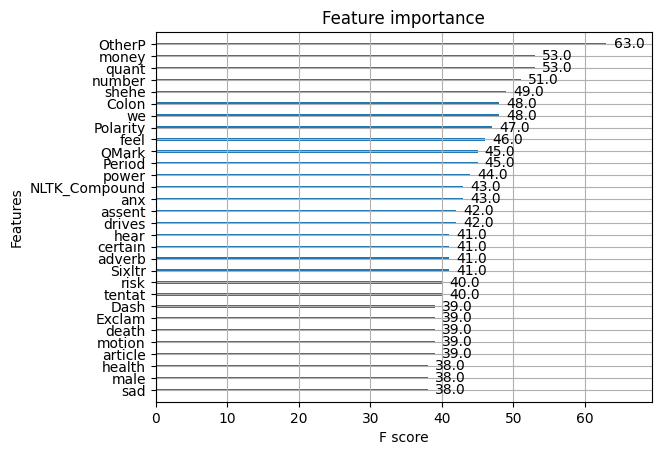

In [ ]:
# Plot feature importance
xgb.plot_importance(clf, max_num_features=30)
#random forest didnt work this was the best option but the accuracy was worse

In [ ]:
#Hybrid with everything
X_new =
df2_reset = df2.reset_index(drop=True)


In [ ]:
longformer_df = pd.DataFrame(X_reduced)
# Reset index of X_new for a consistent concatenation
X_new_reset = X_new.reset_index(drop=True)
df2_reset = df2.reset_index(drop=True)
# Concatenate X_new with longformer_df
X_final_combined = pd.concat([X_combined.reset_index(drop=True), df2_reset], axis=1)
X_final_combined

,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function.,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP,Polarity,Subjectivity,NLTK_Compound,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,userid,ope,ope_hl_bol,gender,age,locale,WC,n_like,n_status,n_event,n_group,n_work,n_education,n_tags
0,79.76,49.84,49.65,57.18,12.59,18.03,75.41,44.85,10.62,7.09,3.93,0.69,1.13,0.85,0.49,3.53,5.96,13.49,7.62,4.74,3.32,1.99,14.55,4.17,1.18,1.18,2.43,1.50,5.23,3.44,1.78,0.12,0.53,0.53,7.05,0.32,0.24,0.28,1.13,8.43,1.38,0.97,1.38,2.35,1.22,2.43,2.67,1.30,0.77,0.61,2.03,0.77,0.57,0.32,0.49,7.13,1.94,1.30,2.92,1.62,0.49,2.55,11.14,1.99,15.44,2.07,6.56,7.29,2.43,1.99,0.24,0.89,0.32,0.65,1.54,0.57,0.45,0.32,0.08,0.00,18.27,7.82,3.04,0.49,0.00,0.53,1.46,0.81,1.05,1.74,0.41,0.93,0.02,0.51,-0.97,-1.83,0.59,1.47e-01,-0.41,-0.27,3.56e-02,-0.68,-0.48,-0.26,-0.22,0.08,-0.32,0.14,-0.15,-1.63e-02,-0.08,-0.19,0.10,0.08,-0.14,2.67e-01,8.16e-02,0.05,0.05,0.11,0.18,0.14,0.12,0.02,0.08,2.63e-02,-7.81e-02,-3.48e-02,-0.01,-0.05,8.38e-02,-4.36e-02,4.25e-02,-5.65e-02,-0.15,-6.32e-03,-2.24e-02,-9.41e-02,0.02,-1.07e-01,0.03,-2.85e-02,-1.13e-01,-0.02,5.39e-02,0.09,-8.35e-02,-0.05,-0.07,0.12,0.09,7.76e-02,59a9bd425abebea3bd4a7673cd6f6778,4.40,1,0,24,en_US,2864,31.0,177.0,NaN,3.0,2.0,2.0,2.0
1,32.33,40.50,57.82,80.53,9.39,13.53,91.90,56.25,16.76,9.96,5.84,0.21,2.13,1.03,0.76,6.73,4.46,12.36,9.41,8.52,6.39,2.68,20.12,4.95,1.99,1.99,1.37,1.58,9.48,6.25,3.23,0.27,0.76,0.69,8.72,0.27,0.41,0.69,0.62,18.06,3.16,2.06,3.91,4.05,2.27,4.46,1.79,0.69,0.21,0.76,3.09,0.76,1.58,0.07,0.41,7.97,1.58,2.47,2.61,2.82,0.76,2.40,14.56,2.40,13.67,1.92,6.80,5.49,1.58,0.62,0.34,0.76,0.76,0.14,1.92,0.48,0.96,0.07,0.48,0.00,14.29,6.87,2.27,0.07,0.00,1.85,1.92,0.14,0.00,1.10,0.00,0.07,0.28,0.54,1.00,2.59,-0.47,-8.32e-01,0.30,-0.97,2.50e-01,0.42,0.40,0.22,0.08,0.40,-0.42,-0.16,-0.16,5.89e-02,0.07,-0.55,-0.04,-0.14,-0.12,1.61e-01,-5.75e-02,0.05,0.06,-0.05,0.10,-0.11,0.03,-0.14,0.23,1.85e-01,-1.53e-03,-1.28e-03,-0.15,0.06,-1.64e-01,-3.47e-02,2.92e-02,1.28e-01,0.02,-1.33e-01,-2.50e-02,9.40e-02,0.12,-7.48e-02,0.01,6.50e-02,-3.43e-02,-0.16,9.16e-02,0.13,-9.50e-02,-0.09,-0.03,0.07,0.08,4.69e-02,41aad64ae9d362e1a052fd6ae6ff438c,4.80,1,0,29,en_US,1018,30.0,45.0,NaN,1.0,1.0,1.0,NaN
2,81.87,40.83,80.19,86.26,7.69,15.99,85.10,43.14,10.23,6.92,5.49,0.17,0.64,0.20,0.42,3.31,6.10,13.42,6.47,4.77,4.25,1.56,16.21,5.61,1.33,1.11,2.45,1.36,6.80,5.14,1.66,0.17,0.42,0.32,5.66,0.47,0.47,0.57,0.44,7.81,1.28,0.94,1.80,1.90,1.28,1.53,2.99,1.41,0.64,0.64,3.21,0.82,0.64,0.07,1.63,7.07,1.09,1.51,1.98,2.55,0.42,3.19,10.72,2.30,19.79,3.51,7.41,9.59,3.01,2.89,1.53,0.82,0.42,0.22,2.00,0.22,0.52,0.74,0.35,0.17,29.73,14.48,2.67,0.15,0.02,1.73,7.07,0.37,0.79,1.75,0.25,0.44,0.40,0.62,1.00,2.47,-0.50,-2.93e-03,0.81,0.45,8.50e-02,0.54,0.33,0.07,-0.07,0.29,0.16,-0.15,-0.03,-3.17e-04,-0.15,-0.06,0.18,-0.11,-0.07,-7.44e-03,1.99e-01,-0.18,-0.07,0.15,0.12,0.26,0.39,0.05,0.16,-7.19e-03,-2.76e-01,2.36e-02,0.08,-0.19,3.51e-02,-4.88e-02,-7.24e-02,7.06e-02,-0.19,-5.77e-02,-3.05e-01,1.88e-03,0.07,1.68e-03,0.02,-1.87e-02,1.40e-02,0.02,-4.97e-02,-0.10,-9.94e-03,0.05,-0.05,0.09,-0.02,1.11e-01,6443ba9a045bb6aeb188770f49bf60e4,4.50,1,1,25,en_US,1791,21.0,123.0,NaN,7.0,1.0,NaN,36.0
3,63.11,53.43,72.23,72.35,9.00,14.59,83.71,47.35,12.71,8.71,5.11,0.46,2.09,0.58,0.48,3.99,5.86,11.54,8.86,4.86,5.07,1.71,16.75,4.94,1.94,1.22,1.55,1.88,6.92,4.66,

In [ ]:
# Concatenate df2 with X_combined
X_final_combined = X_final_combined.drop(['ope', 'ope_hl_bol','userid','locale'], axis=1)
from sklearn.impute import SimpleImputer

numerical_cols = X_final_combined.select_dtypes(include=['int64', 'float64']).columns
from sklearn.impute import SimpleImputer

# Initialize the imputer to replace missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to your data
X_final_combined[numerical_cols] = imputer.fit_transform(X_final_combined[numerical_cols])
X_final_combined

,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function.,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP,Polarity,Subjectivity,NLTK_Compound,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,gender,age,WC,n_like,n_status,n_event,n_group,n_work,n_education,n_tags
0,79.76,49.84,49.65,57.18,12.59,18.03,75.41,44.85,10.62,7.09,3.93,0.69,1.13,0.85,0.49,3.53,5.96,13.49,7.62,4.74,3.32,1.99,14.55,4.17,1.18,1.18,2.43,1.50,5.23,3.44,1.78,0.12,0.53,0.53,7.05,0.32,0.24,0.28,1.13,8.43,1.38,0.97,1.38,2.35,1.22,2.43,2.67,1.30,0.77,0.61,2.03,0.77,0.57,0.32,0.49,7.13,1.94,1.30,2.92,1.62,0.49,2.55,11.14,1.99,15.44,2.07,6.56,7.29,2.43,1.99,0.24,0.89,0.32,0.65,1.54,0.57,0.45,0.32,0.08,0.00,18.27,7.82,3.04,0.49,0.00,0.53,1.46,0.81,1.05,1.74,0.41,0.93,0.02,0.51,-0.97,-1.83,0.59,1.47e-01,-0.41,-0.27,3.56e-02,-0.68,-0.48,-0.26,-0.22,0.08,-0.32,0.14,-0.15,-1.63e-02,-0.08,-0.19,0.10,0.08,-0.14,2.67e-01,8.16e-02,0.05,0.05,0.11,0.18,0.14,0.12,0.02,0.08,2.63e-02,-7.81e-02,-3.48e-02,-0.01,-0.05,8.38e-02,-4.36e-02,4.25e-02,-5.65e-02,-0.15,-6.32e-03,-2.24e-02,-9.41e-02,0.02,-1.07e-01,0.03,-2.85e-02,-1.13e-01,-0.02,5.39e-02,0.09,-8.35e-02,-0.05,-0.07,0.12,0.09,7.76e-02,0.0,24.0,2864.0,31.0,177.0,23.66,3.0,2.00,2.00,2.00
1,32.33,40.50,57.82,80.53,9.39,13.53,91.90,56.25,16.76,9.96,5.84,0.21,2.13,1.03,0.76,6.73,4.46,12.36,9.41,8.52,6.39,2.68,20.12,4.95,1.99,1.99,1.37,1.58,9.48,6.25,3.23,0.27,0.76,0.69,8.72,0.27,0.41,0.69,0.62,18.06,3.16,2.06,3.91,4.05,2.27,4.46,1.79,0.69,0.21,0.76,3.09,0.76,1.58,0.07,0.41,7.97,1.58,2.47,2.61,2.82,0.76,2.40,14.56,2.40,13.67,1.92,6.80,5.49,1.58,0.62,0.34,0.76,0.76,0.14,1.92,0.48,0.96,0.07,0.48,0.00,14.29,6.87,2.27,0.07,0.00,1.85,1.92,0.14,0.00,1.10,0.00,0.07,0.28,0.54,1.00,2.59,-0.47,-8.32e-01,0.30,-0.97,2.50e-01,0.42,0.40,0.22,0.08,0.40,-0.42,-0.16,-0.16,5.89e-02,0.07,-0.55,-0.04,-0.14,-0.12,1.61e-01,-5.75e-02,0.05,0.06,-0.05,0.10,-0.11,0.03,-0.14,0.23,1.85e-01,-1.53e-03,-1.28e-03,-0.15,0.06,-1.64e-01,-3.47e-02,2.92e-02,1.28e-01,0.02,-1.33e-01,-2.50e-02,9.40e-02,0.12,-7.48e-02,0.01,6.50e-02,-3.43e-02,-0.16,9.16e-02,0.13,-9.50e-02,-0.09,-0.03,0.07,0.08,4.69e-02,0.0,29.0,1018.0,30.0,45.0,23.66,1.0,1.00,1.00,124.34
2,81.87,40.83,80.19,86.26,7.69,15.99,85.10,43.14,10.23,6.92,5.49,0.17,0.64,0.20,0.42,3.31,6.10,13.42,6.47,4.77,4.25,1.56,16.21,5.61,1.33,1.11,2.45,1.36,6.80,5.14,1.66,0.17,0.42,0.32,5.66,0.47,0.47,0.57,0.44,7.81,1.28,0.94,1.80,1.90,1.28,1.53,2.99,1.41,0.64,0.64,3.21,0.82,0.64,0.07,1.63,7.07,1.09,1.51,1.98,2.55,0.42,3.19,10.72,2.30,19.79,3.51,7.41,9.59,3.01,2.89,1.53,0.82,0.42,0.22,2.00,0.22,0.52,0.74,0.35,0.17,29.73,14.48,2.67,0.15,0.02,1.73,7.07,0.37,0.79,1.75,0.25,0.44,0.40,0.62,1.00,2.47,-0.50,-2.93e-03,0.81,0.45,8.50e-02,0.54,0.33,0.07,-0.07,0.29,0.16,-0.15,-0.03,-3.17e-04,-0.15,-0.06,0.18,-0.11,-0.07,-7.44e-03,1.99e-01,-0.18,-0.07,0.15,0.12,0.26,0.39,0.05,0.16,-7.19e-03,-2.76e-01,2.36e-02,0.08,-0.19,3.51e-02,-4.88e-02,-7.24e-02,7.06e-02,-0.19,-5.77e-02,-3.05e-01,1.88e-03,0.07,1.68e-03,0.02,-1.87e-02,1.40e-02,0.02,-4.97e-02,-0.10,-9.94e-03,0.05,-0.05,0.09,-0.02,1.11e-01,1.0,25.0,1791.0,21.0,123.0,23.66,7.0,1.00,2.04,36.00
3,63.11,53.43,72.23,72.35,9.00,14.59,83.71,47.35,12.71,8.71,5.11,0.46,2.09,0.58,0.48,3.99,5.86,11.54,8.86,4.86,5.07,1.71,16.75,4.94,1.94,1.22,1.55,1.88,6.92,4.66,2.17,0.26,0.59,0.44,8.09,0.40,0.38,1.04,0.26,9.55,1.63,0.64,1.84,2.49,1.37,2.80,2.55,1.20,0.54,0.66,3.05,0.92,0.51,0.03,1.17,6.69,2.

In [ ]:
#Classification Model

X_train, X_test, y_train, y_test = train_test_split(X_final_combined, y, test_size=0.2, random_state=42)

clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc_score}")

Accuracy: 0.595
AUC: 0.6256833637050535


PT6:


In [ ]:
#TOPIC MODEL
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from gensim.models import Phrases
from gensim.corpora import Dictionary

# Create bigrams
bigram = Phrases(df['preprocessed_message'], min_count=5)
bigram_reviews = [bigram[doc] for doc in df['preprocessed_message']]
texts_with_bigrams = bigram_reviews

# Create a dictionary from the bigram reviews and filter extremes
dictionary = Dictionary(bigram_reviews)
dictionary.filter_extremes(no_below=60, no_above=0.1)

# Create the Bag of Words (BOW) corpus
corpus = [dictionary.doc2bow(doc) for doc in bigram_reviews]

texts = df['preprocessed_message'].tolist()

# Apply the bigram model to the texts
texts_with_bigrams = [bigram[doc] for doc in texts]

print(len(dictionary))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


871


In [ ]:
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
!pip install pyldavis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
#Model 1 LDA
def compute_lda_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                         chunksize=1500, passes=20, iterations=400,
                         eval_every=None, gamma_threshold=0.001,
                         alpha='auto', eta='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_lda_coherence_values(dictionary=dictionary, corpus=corpus, texts=bigram_reviews, start=4, limit=18, step=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


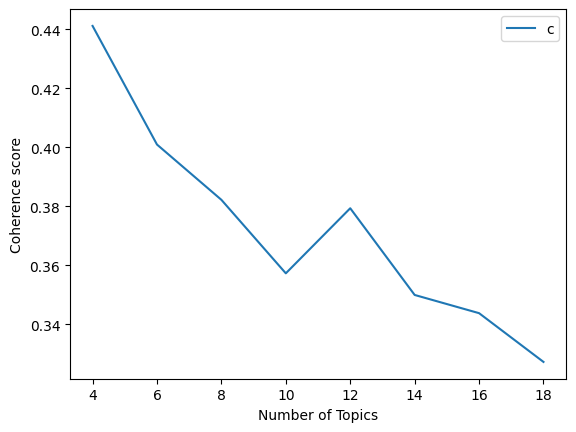

Optimal Number of Topics: 4, Coherence Score: 0.44112239577232315


In [ ]:
# Find the index of the highest coherence score
optimal_index = coherence_values.index(max(coherence_values))
optimal_num_topics = 4 + 2 * optimal_index  # Adjust based on your 'start' and 'step'

# Plot the coherence scores
plt.plot(range(4, 19, 2), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

print(f"Optimal Number of Topics: {optimal_num_topics}, Coherence Score: {coherence_values[optimal_index]}")

In [ ]:
start, limit, step = 2, 10, 2
topic_range = range(start, limit + 1, step)

# Find the index of the highest coherence score
max_coherence_val_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[max_coherence_val_index]
optimal_num_topics = list(topic_range)[max_coherence_val_index]

print(f"Optimal Number of Topics: {optimal_num_topics}, Coherence Score: {coherence_values[max_coherence_val_index]}")

Optimal Number of Topics: 2, Coherence Score: 0.44112239577232315


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
optimal_model = model_list[optimal_index]
topics = optimal_model.show_topics(num_topics=-1, formatted=True)

for topic_num, topic in topics:
    print(f"Topic {topic_num}: {topic}")
    # Manually label each topic based on interpretation
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)
pyLDAvis.display(vis)

Topic 0: 0.027*"ppl" + 0.023*"aint" + 0.022*"wit" + 0.021*"cuz" + 0.016*"wat" + 0.015*"goin" + 0.015*"dnt" + 0.013*"lil" + 0.012*"bout" + 0.012*"yall"
Topic 1: 0.011*"pray" + 0.011*"thankful" + 0.011*"child" + 0.010*"bless" + 0.010*"wonderful" + 0.009*"son" + 0.008*"husband" + 0.008*"proud" + 0.008*"sister" + 0.006*"prayer"
Topic 2: 0.004*"forever" + 0.004*"dont_care" + 0.004*"pain" + 0.004*"hold" + 0.004*"high" + 0.004*"part" + 0.004*"hair" + 0.004*"moment" + 0.004*"thought" + 0.004*"light"
Topic 3: 0.009*"haha" + 0.008*"yay" + 0.007*"homework" + 0.006*"study" + 0.006*"excited" + 0.006*"summer" + 0.006*"hang" + 0.005*"look_forward" + 0.005*"book" + 0.005*"friday"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Showcase the 4 topics
for topic_num, topic in optimal_model.print_topics(num_topics=-1, num_words=10):
    print(f"Topic {topic_num}:")

    # Splitting each term weight pair and printing them separately
    for term in topic.split('+'):
        term_weight, term_word = term.split('*')
        # Remove the quotation marks and extra spaces
        term_word = term_word.replace('"', '').strip()
        print(f"    {term_word} ({term_weight.strip()})")
    print("\n")

Topic 0:
    ppl (0.027)
    aint (0.023)
    wit (0.022)
    cuz (0.021)
    wat (0.016)
    goin (0.015)
    dnt (0.015)
    lil (0.013)
    bout (0.012)
    yall (0.012)


Topic 1:
    pray (0.011)
    thankful (0.011)
    child (0.011)
    bless (0.010)
    wonderful (0.010)
    son (0.009)
    husband (0.008)
    proud (0.008)
    sister (0.008)
    prayer (0.006)


Topic 2:
    forever (0.004)
    dont_care (0.004)
    pain (0.004)
    hold (0.004)
    high (0.004)
    part (0.004)
    hair (0.004)
    moment (0.004)
    thought (0.004)
    light (0.004)


Topic 3:
    haha (0.009)
    yay (0.008)
    homework (0.007)
    study (0.006)
    excited (0.006)
    summer (0.006)
    hang (0.006)
    look_forward (0.005)
    book (0.005)
    friday (0.005)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Model 2 LSA
#For some reason C_V wasnt working, so I had to use u_mass but issue is different values
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=df['preprocessed_message'].tolist(), start=2, limit=10, step=2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' 

In [ ]:
# Find the index of the highest coherence score
max_coherence_val_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[max_coherence_val_index]
optimal_num_topics = range(2, 11, 2)[max_coherence_val_index]

print(f"Optimal Number of Topics: {optimal_num_topics}, Coherence Score: {coherence_values[max_coherence_val_index]}")


Optimal Number of Topics: 4, Coherence Score: -2.731646223089294


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics = optimal_model.show_topics(num_topics=optimal_num_topics, formatted=False)
for topic_num, topic_terms in topics:
    print(f"Topic {topic_num}:")
    for term, weight in topic_terms:
        print(f"    {term} ({weight:.3f})")
    print("\n")


Topic 0:
    haha (0.085)
    yay (0.073)
    cuz (0.071)
    sister (0.069)
    book (0.069)
    boy (0.067)
    homework (0.066)
    hair (0.066)
    dance (0.064)
    hang (0.064)


Topic 1:
    wit (0.388)
    aint (0.288)
    wat (0.277)
    dnt (0.270)
    dat (0.235)
    ppl (0.233)
    cuz (0.189)
    bout (0.166)
    goin (0.152)
    luv (0.122)


Topic 2:
    haha (0.656)
    study (0.173)
    bless (-0.162)
    homework (0.154)
    text (0.146)
    child (-0.141)
    pray (-0.131)
    son (-0.118)
    thankful (-0.108)
    repost (-0.104)


Topic 3:
    haha (-0.478)
    bless (-0.269)
    thankful (-0.186)
    wonderful (-0.166)
    pray (-0.158)
    husband (-0.144)
    sister (-0.137)
    look_forward (-0.112)
    child (-0.111)
    lord (-0.111)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#hierarchical LDA (hLDA)
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import HdpModel

# Compute coherence values for different numbers of topics
def compute_hlda_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = HdpModel(corpus=corpus, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values
model_list, coherence_values = compute_hlda_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts_with_bigrams, start=start, limit=limit, step=step)

# Find the optimal number of topics based on coherence score
max_coherence_val_index = coherence_values.index(max(coherence_values))
optimal_num_topics = start + max_coherence_val_index * step

print(f"Optimal Number of Topics: {optimal_num_topics}, Coherence Score: {coherence_values[max_coherence_val_index]}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Optimal Number of Topics: 8, Coherence Score: 0.18306383629351985


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


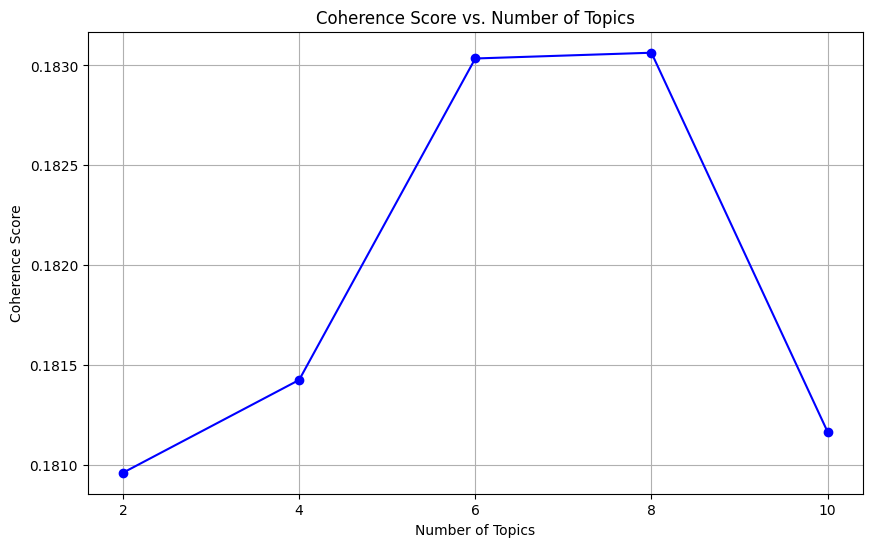

In [ ]:
import matplotlib.pyplot as plt

# Plotting the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(range(start, limit + 1, step), coherence_values, marker='o', color='b', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(range(start, limit + 1, step))
plt.grid(True)
plt.show()